<img style="float:right; max-width:400px" src="imgs/visestruka.png" width="60%" />

# Множественная линейная регрессия

До сих пор мы использовали простую линейную регрессию, где есть только одна независимая переменная $x$. 
*Множественная* линейная регрессия относится к линейной регрессии с *несколькими* независимыми переменными $x_1, x_2,...x_n$.
Пример множественной линейной регрессии: $y = 2.7 x_1 + 3.4 x_2 + 5$.

Ниже мы показываем:
- пример [множественной линейной регрессии](#пример-множественной-регрессии),
- дополнительное [предположение об идеальной коллинеарности](#коллинеарность),
- проверку линейности с использованием [t-теста](#t-тест) и [F-теста](#f-тест),
- как [оцениваем модель](#оценка-модели).

Загружаем необходимые пакеты и набор данных:


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1.)

In [4]:
df = pd.read_csv('data/housing.csv', sep=',')
df.head()

,price,lotsize(m^2),bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,74700,658.4799,3,1,1,1,1,1,0,0,2,1
1,85000,652.4388,3,1,1,1,0,1,0,1,2,1
2,68500,650.5800,3,1,2,1,0,1,0,0,0,0
3,82900,650.5800,3,1,1,1,0,1,0,0,2,1
4,86000,641.2860,3,2,1,1,1,1,0,0,0,1


## Пример множественной линейной регрессии

До этого мы строили модель, предсказывающую цену дома $Y$ на основе площади участка $X$. Теперь мы вводим дополнительную независимую переменную и создаем модель множественной линейной регрессии, предсказывающую цену дома $Y$ на основе площади участка $X_1$ и количества спален $X_2$.

In [5]:
col_names = ['lotsize(m^2)', 'bedrooms']
x = df[col_names]
y = df['price']

x_with_const = sm.add_constant(x)
model = sm.OLS(y, x_with_const).fit()
y_pred = model.predict(x_with_const)
intercept, slope0, slope1 = model.params

print(f'y = {slope0:.2f} x1 + {slope1:.2f} x2 + {intercept:.2f}')

y = 78.02 x1 + 2546.39 x2 + 22835.34


Давайте создадим модель, в которой мы используем все доступные независимые переменные. Для этого мы загрузим все независимые переменные, доступные в нашем наборе данных, используя код `x = df.drop(columns=['price'])`.

In [6]:
x = df.drop(columns=['price'])

y = df['price']

x_with_const = sm.add_constant(x)
all_vars_model = sm.OLS(y, x_with_const).fit()

## Коллинеарность

Помимо предположений L.I.N.E. в множественной регрессии, мы также должны удовлетворять еще одному предположению: **отсутствие идеальной коллинеарности между 2 или более независимыми переменными**.

*Идеальная коллинеарность между двумя переменными $x_1$ и $x_2$ существует, когда они связаны линейной функцией: $x_2 = a x_1 + b$.*

Пример: предположим, что в данных есть еще одна колонка с именем `toilet` (копия колонки `bathrms`). Эта переменная находится в линейной зависимости от переменной `bathrms`, так что $x_2 = 1 x_1 + 0$. В этом случае существует идеальная коллинеарность, и эту колонку `toilet` следует исключить из-за возникновения идеальной коллинеарности.

*Примечание: мы рассматриваем идеальную коллинеарность только между ровно 2 переменными.*

In [7]:
# # duboka kopija DataFrame objekta
df_perfect_collinearity = df.copy() 
df_perfect_collinearity['toilet'] = -1 * df_perfect_collinearity['bathrms']
df_perfect_collinearity.head()

    # making non-collinear
# import time
# def generate_seed():
#     current_time = int(time.time() * 1000)  # Умножаем на 1000, чтобы получить миллисекунды
#     return current_time % (2**32)

# df_perfect_collinearity = df.copy()
# np.random.RandomState(42)
# df_perfect_collinearity['toilet'] = 2 * df_perfect_collinearity['bathrms']

# print(df_perfect_collinearity['toilet'][0])
# df_perfect_collinearity['toilet'][0] = -7
# print(df_perfect_collinearity['toilet'][0])

# for i in range (len(df_perfect_collinearity)):
#     df_perfect_collinearity['toilet'][i] **= 1/3*np.random.randint(15)*np.random.randint(15)
#     np.random.seed(generate_seed())

# df_perfect_collinearity.head()

,price,lotsize(m^2),bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea,toilet
0,74700,658.4799,3,1,1,1,1,1,0,0,2,1,-1
1,85000,652.4388,3,1,1,1,0,1,0,1,2,1,-1
2,68500,650.5800,3,1,2,1,0,1,0,0,0,0,-1
3,82900,650.5800,3,1,1,1,0,1,0,0,2,1,-1
4,86000,641.2860,3,2,1,1,1,1,0,0,0,1,-2


## Как обнаружить коллинеарность с использованием матрицы корреляции

Коллинеарность и корреляция - два похожих понятия. **Корреляция** относится к линейной связи двух переменных, а **коллинеарность** относится к линейной связи двух *независимых* переменных в *линейной регрессии*.

**Ковариация** - **коэффициент корреляции** - это конкретное число в диапазоне $[-1,1]$, измеряющее линейность между переменными. Значение $-1$ означает идеальную отрицательную коллинеарность, а $+1$ - идеальную положительную коллинеарность. Сильная корреляция (но не идеальная) - значения в интервале $ (-1, -0.8] \cup [0.8, 1)$.

Матрица корреляции показывает значения коэффициентов корреляции для всех пар переменных.
- Если матрица корреляции показывает идеальную положительную или отрицательную коллинеарность ($+1$ или $-1$) между независимыми переменными (в нашем случае для столбца `toilet`), то этот столбец следует удалить.
- Если матрица корреляции показывает сильную корреляцию между независимыми переменными, тогда предположение о коллинеарности не нарушено. *Совет*: если наблюдается сильная корреляция между независимыми переменными, стоит проверить модель без этих переменных, возможно, получится лучшая производительность, но это не гарантировано.
- Другие корреляции (даже если они сильные) не являются проблематичными.


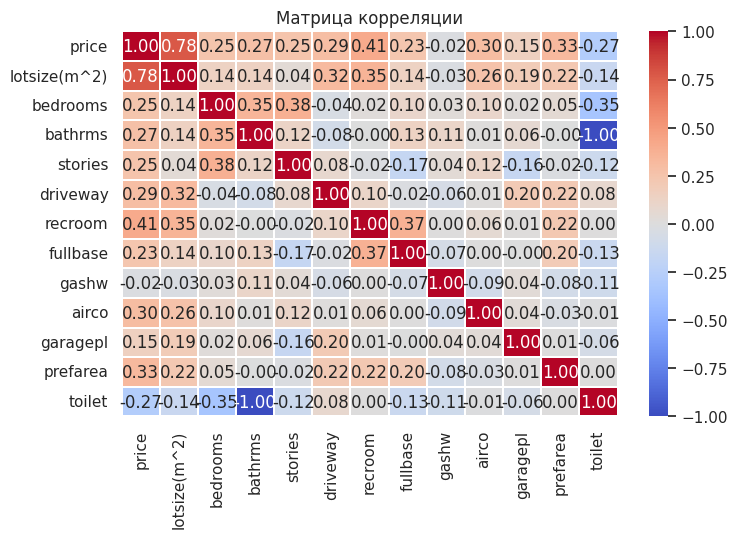

In [8]:
plt.figure(figsize=(8,5))  # Устанавливаем размер графика

correlation_matrix = df_perfect_collinearity.corr()  # Вычисляем матрицу корреляции

sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.1)
plt.title('Матрица корреляции')
plt.show()

Мы видим, что искусственно созданный столбец `toilet` находится в состоянии идеальной коллинеарности с `bathrms`, поэтому его следует удалить.


## T-тест

В простой регрессии мы проверяли линейность визуально с помощью графика или с использованием **t-теста**.
T-тест также используется в множественной регрессии и вычисляется для каждой переменной отдельно.
В множественной регрессии t-тест проверяет значимость отдельных переменных **в присутствии других переменных**.
Для каждой переменной отдельно мы тестируем, находится ли она в линейной связи с $Y$, но при наличии других переменных.

Может оказаться, что какая-то переменная не является значимой, когда модель имеет доступ к другим переменным. Это происходит, когда две переменные коррелируют (например, `toilet` и `bathrms` или `bedrooms` и `stories`).

Пример сравнения двух моделей:
1. Модель простой регрессии, предсказывающая цену $Y$ на основе числа комнат $X$. Мы видим, что `p-значение ≤ 0.05` для переменной `bedrooms` => мы уверены на 95%, что связь линейная ✅.
2. Модель множественной регрессии, предсказывающая цену $Y$ на основе всех переменных. Мы видим, что `p-значение > 0.05` для переменной `bedrooms` => мы не можем заключить о линейности, потому что t-тест недействителен. Мы заключаем, что переменная `bedrooms` не оказывает большого влияния в присутствии других переменных.

*Примечание:* когда `p-значение > 0.05` для некоторой независимой переменной, вероятно, мы можем получить лучшую модель, удалив эту переменную.

*Напоминание:* чтобы увидеть p-значение, мы читаем столбец `P>|t|` для каждой переменной.


In [9]:
# pomocna funkcija koja vraca fitovan model
def get_fitted_model(x, y):
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()
    return model

bedrooms_model = get_fitted_model(x=df['bedrooms'], y=df['price'])
all_vars_model = get_fitted_model(x=df.drop(columns=['price']), y=df['price'])

print(bedrooms_model.summary())
print(all_vars_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     18.43
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           2.44e-05
Time:                        20:19:38   Log-Likelihood:                -3034.6
No. Observations:                 280   AIC:                             6073.
Df Residuals:                     278   BIC:                             6080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.853e+04   3069.052     15.813      0.0

## F-тест

F-тест проверяет, есть ли хотя бы одна независимая переменная в линейной связи с $Y$. F-тест более простой, чем t-тест, потому что он не тестирует линейность в присутствии других переменных, как это делает t-тест.

Как и в случае t-теста, у F-теста есть p-значение. Если p-значение маленькое, то значение F редкое, и по крайней мере одна переменная $X$ имеет линейную связь с $Y$.

**Что считается *маленьким* p-значением?**

Обычно в качестве порога берется значение $\alpha = 0.05 = 5\%$ (уровень значимости). Если конкретное `p-значение ≤ 0.05`, тогда мы на 95% уверены, что по крайней мере одна переменная $X$ имеет линейную связь с $Y$ ✅.

Значения мы читаем из таблицы `statsmodels`, вызывая метод `summary()`: значение F обозначено как `F-statistic`, а p-значение обозначено как `Prob (F-statistic)`.

В конкретном примере мы видим, что p-значение F-теста маленькое, и мы заключаем, что по крайней мере одна переменная $X$ имеет линейную связь с $Y$ ✅.

Для получения конкретного p-значения:


In [10]:
alpha = 0.05
if model.f_pvalue <= alpha:
    print('по крайней мере, одна переменная X имеет линейную зависимость с переменной Y')
else:
    print('возможно, ни одна переменная не имеет значимой линейной зависимости с Y')

по крайней мере, одна переменная X имеет линейную зависимость с переменной Y


## Оценка модели

Как мы можем определить, какая модель лучше: модель с одной переменной, двумя или более?
Мы предполагаем, что чем лучше мы описываем дом (чем больше мы знаем о доме), тем лучше мы предсказываем цену дома, но мы не уверены, что это всегда так. Поэтому нам нужен способ измерить, насколько хороша модель.

Коэффициент детерминации - $r^2$ - это способ измерения качества модели. Он принимает значения в диапазоне $[0, 1]$. Чем ближе $r^2$ к 1, тем лучше модель; чем дальше от 1, тем хуже модель.

Сравниваем $r^2$ на примере двух моделей: первая предсказывает цену на основе площади участка, а вторая на основе количества комнат.


In [11]:
# Прогноз цены на основе площади участка
lotsize_model = get_fitted_model(x=df['lotsize(m^2)'], y=df['price'])
print(f'r^2 = {lotsize_model.rsquared:.3f} для модели по площади участка')

# Прогноз цены на основе количества комнат
bedrooms_model = get_fitted_model(x=df['bedrooms'], y=df['price'])
print(f'r^2 = {bedrooms_model.rsquared:.3f} для модели по количеству комнат')

model1 = get_fitted_model(x=df[['bedrooms', 'lotsize(m^2)']], y=df['price'])
print(f'r^2 = {model1.rsquared:.3f} для модели по количеству комнат и по площади')

model11 = get_fitted_model(x=df.drop(columns=['price']), y=df['price'])
print(f'r^2 = {model11.rsquared:.3f} для модели по всем переменным')

model11 = get_fitted_model(x=df.drop(columns=['price', 'bedrooms', 'gashw']), y=df['price'])
print(f'r^2 = {model11.rsquared:.3f} для модели по всем переменным')

r^2 = 0.608 для модели по площади участка
r^2 = 0.062 для модели по количеству комнат
r^2 = 0.628 для модели по количеству комнат и по площади
r^2 = 0.742 для модели по всем переменным
r^2 = 0.742 для модели по всем переменным


Видим, что $r^2$ больше для модели `lotsize`, что означает, что площадь участка лучше описывает цену дома, чем количество комнат.

### Поправленный (уточненный, скорректированный) $r^2$
Когда мы добавляем независимые переменные в модель, правило гласит, что значение $r^2$ никогда не уменьшается. Поскольку $r^2$ не уменьшается, мы могли бы заключить, что всегда полезно добавить независимую переменную в модель ➡️ Этот вывод неверен! ❌

Новая независимая переменная, которую мы добавляем в модель, может быть полезной, но также может быть бесполезной или содержать неверные значения. Введение *плохой* независимой переменной ухудшает качество модели, и мера $r^2$ этого не покажет (потому что она никогда не уменьшается).

Поэтому в случае множественной регрессии мы будем использовать **поправленный $r^2$** ✅. Поправленный $r^2$ - это модификация меры $r^2$, учитывающая сложность модели и количество данных. Он является надежным показателем качества модели.

Сравним $r^2$ и поправленный $r^2$ на примере двух моделей: первая предсказывает цену на основе всех независимых переменных, а вторая на основе некоторых (во второй модели мы уберем `gashw` - газовый водонагреватель и `bedrooms` - количество комнат).


In [12]:
# Прогноз цены на основе всех независимых переменных
all_vars_model = get_fitted_model(x=df.drop(columns=['price']), y=df['price'])
print(f'r^2 = {all_vars_model.rsquared:.5f} и скорректированный r^2 = {all_vars_model.rsquared_adj:.5f}')

# Прогноз цены на основе некоторых переменных
some_vars_model = get_fitted_model(x=df.drop(columns=['price', 'gashw', 'bedrooms']), y=df['price'])
print(f'r^2 = {some_vars_model.rsquared:.5f} и скорректированный r^2 = {some_vars_model.rsquared_adj:.5f}')


r^2 = 0.74184 и скорректированный r^2 = 0.73125
r^2 = 0.74183 и скорректированный r^2 = 0.73323


*Какая модель лучше: `all_vars_model` или `filtered_vars_model`?*

Если мы смотрим только на меру $r^2$, мы бы пришли к ошибочному выводу, что `all_vars_model` является лучшей моделью, потому что у нее больше значение $r^2$. Это неверный вывод! ❌

Правильно смотреть на поправленную меру $r^2$ и сделать вывод, что `filtered_vars_model` является лучшей моделью, потому что у нее больше значение поправленного $r^2$ ✅.


### Тренировка/валидация/тест

Оценка модели с разделением данных на *тренировочный/валидационный/тестовый* набор предполагает разделение доступных данных на тренировочный, валидационный и тестовый наборы. Обычно данные делятся в соотношении: $80/20/20$. Иногда другое соотношение более предпочтительно, в зависимости от объема данных и решаемой задачи.

**Тренировочный набор** - 
Модель обучается на тренировочном наборе. Обучение модели включает в себя поиск параметров модели для минимизации ошибки. В нашем случае параметры модели - это коэффициенты при независимых переменных $x_1, x_2,...x_n$.

**Валидационный набор** -
Валидационный набор - это отдельный набор данных, который модель не видела (не входит в тренировочный набор). Эти данные модель *не видит* в процессе обучения. 
На данных из валидационного набора мы измеряем производительность модели с использованием какой-то метрики (например, поправленный $r^2$, SSE, ...). Результаты измерений показывают, насколько хорошо модель обобщается на данных, которые она еще не видела.

Пример: валидационный набор используется для оценки $r^2$ на домах, которые модель еще не видела (метрика вычисляется на валидационном наборе). Получив меру, она указывает, насколько хорошо обученная модель обобщает на новых данных. Затем мы можем попробовать добавить или удалить какой-то столбец и посмотреть, как изменится мера. Итеративно мы получаем модель, которая лучше всего обобщает.

**Тестовый набор** -
Тестовый набор используется для оценки модели на неизвестных данных. Тестовый набор оценивает способность модели обобщаться на новых данных. Аналогично валидационному набору, с тем отличием, что тестовый набор оценивается *только один раз*, в случае наличия доступа к тестовому набору. Часто у нас нет доступа к тестовому набору, и эти данные будут теми данными, которые поступают в реальном времени, на которых обученная модель делает предсказания.

Пример:


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

x = df.drop(columns=['price'])
y = df['price']

# Разделение на тренировочный и валидационный набор
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=42)

# Обучение модели на тренировочных данных
all_vars_model = get_fitted_model(x=x_train, y=y_train)

# Предсказание на данных из валидационного набора
x_with_const = sm.add_constant(x_val)
y_pred = all_vars_model.predict(x_with_const)

# Вычисление метрики r^2, но на валидационном наборе
rsquared_val_data = r2_score(y_true=y_val, y_pred=y_pred)

print(f'{rsquared_val_data:.2f}')


0.67


*Замечание: $r^2$ и скорректированный $r^2$ не всегда являются лучшими метриками для оценки производительности модели. Иногда лучше использовать метрики SSE, MSE или RMSE.*

## Задачи
**TODO 1:** Создайте регрессионную модель, предсказывающую стоимость дома с использованием пакета `statsmodels` и всех атрибутов. Создайте функцию `def are_assumptions_satisfied(model, x, y, p_value_thresh=0.01):`, которая проверяет, выполнены ли все предпосылки. Проверьте предпосылки на тренировочном наборе.

**TODO 2:** Используйте регрессионную модель из **TODO 1** и проверьте, удовлетворяет ли каждая переменная t-тесту. С использованием результатов t-теста улучшите текущую модель, удалив соответствующие атрибуты, чтобы получить лучшую меру на валидационном наборе. Модель должна удовлетворять предпосылкам регрессии (используйте метод `are_assumptions_satisfied` из **TODO 1**).

**TODO 3:** Какую меру на тестовых данных из Европы [data/skincancer_europe.csv](data/skincancer_europe.csv) достигает лучшая модель множественной линейной регрессии, обученная на данных из Америки [data/skincancer.csv](data/skincancer.csv)? Для тренировочных данных использовать 80% доступных данных.

*Примечание: для тренировочных данных использовать 90% доступных данных. В качестве порога p-значения во всех предположениях использовать значение 0.01. В качестве меры использовать скорректированный $r^2$.*
